# Lab3 : Pose Estimation from images
---
> By `Sandra Mourali`

In [4]:
!pip install opencv-python mediapipe

Defaulting to user installation because normal site-packages is not writeable


##### Imports :

In [5]:
import math
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt

#### Creating Mediapipe instance :

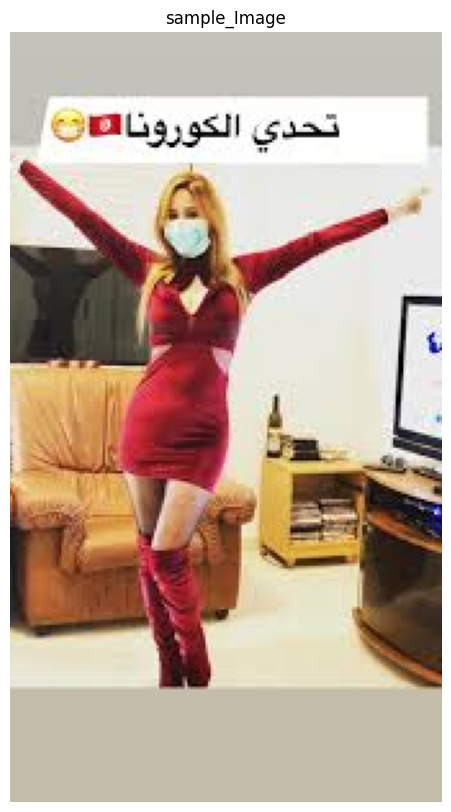

NOSE:
x: 0.4047573208808899
y: 0.2500703036785126
z: -0.9193497896194458
visibility: 0.9999802112579346

LEFT_EYE_INNER:
x: 0.41354575753211975
y: 0.23758363723754883
z: -0.8899890184402466
visibility: 0.9999300241470337

NOSE:
x: 67.9992299079895
y: 75.02109110355377
z: -154.4507646560669
visibility: 0.9999802112579346

LEFT_EYE_INNER:
x: 69.47568726539612
y: 71.27509117126465
z: -149.51815509796143
visibility: 0.9999300241470337



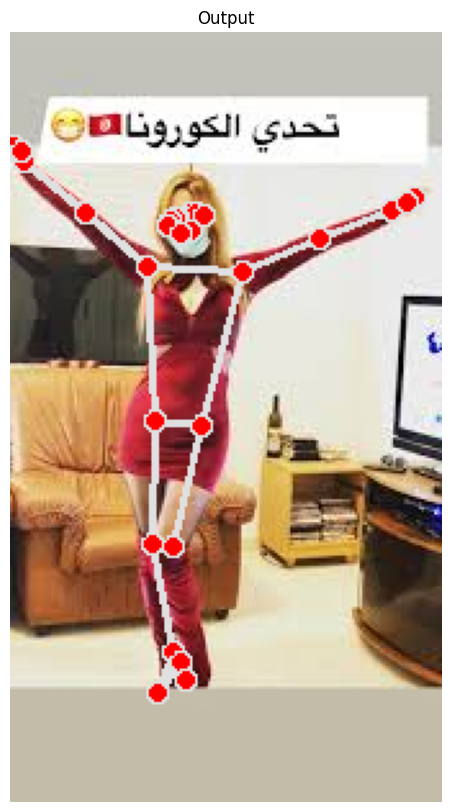

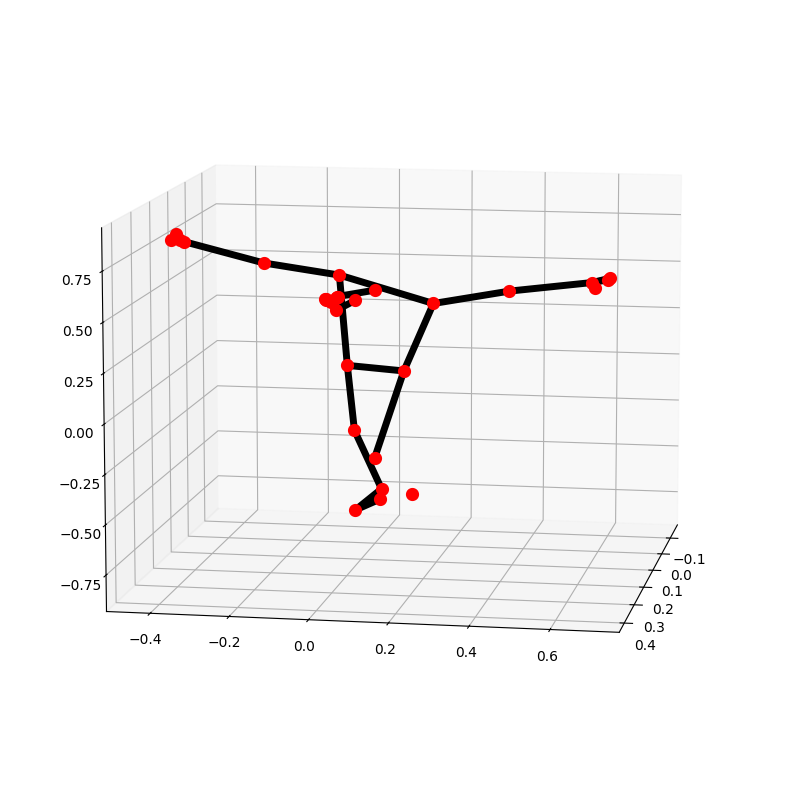

In [6]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2)
mp_drawing = mp.solutions.drawing_utils

sample_img  = cv2.imread('../images/unknown.jpg')
plt.figure(figsize=[10,10])
plt.title("sample_Image"); plt.axis('off'); plt.imshow(sample_img[:,:,::-1]); plt.show()

results = pose.process(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))

if results.pose_landmarks:
    for i in range(2):
        print(f'{mp_pose.PoseLandmark(i).name}:\n{results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value]}')

image_height, image_width, _ = sample_img.shape

if results.pose_landmarks:
    for i in range(2):
        print(f'{mp_pose.PoseLandmark(i).name}:')
        print(f'x: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].x * image_width}')
        print(f'y: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].y * image_height}')
        print(f'z: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].z * image_width}')
        print(f'visibility: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].visibility}\n')

img_copy = sample_img.copy()

if results.pose_landmarks:
    mp_drawing.draw_landmarks(image=img_copy, landmark_list=results.pose_landmarks, connections=mp_pose.POSE_CONNECTIONS)
    fig = plt.figure(figsize=[10, 10])
    plt.title("Output"); plt.axis('off'); plt.imshow(img_copy[:,:,::-1]); plt.show()

mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

##### Pose Detection :

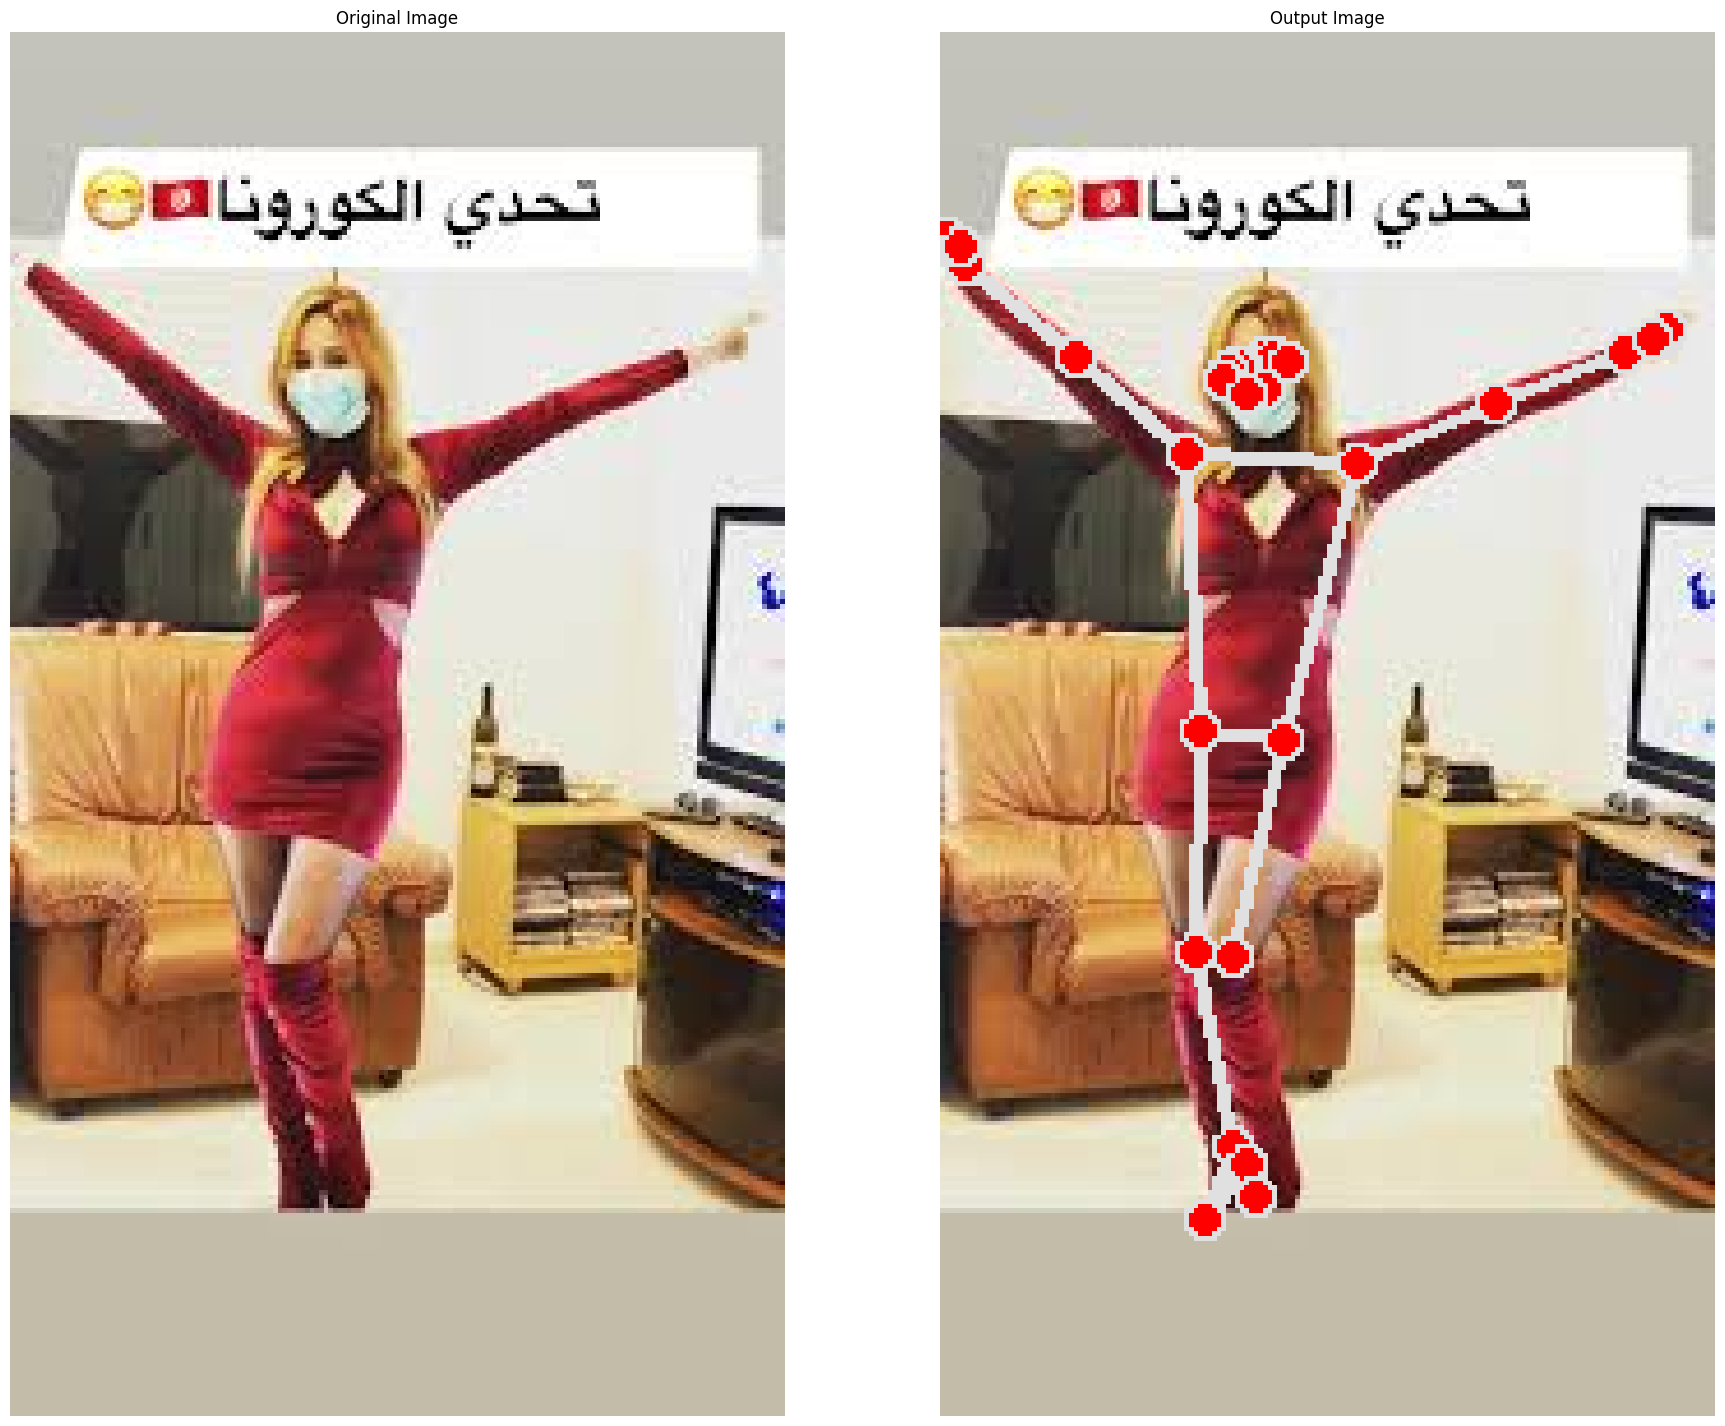

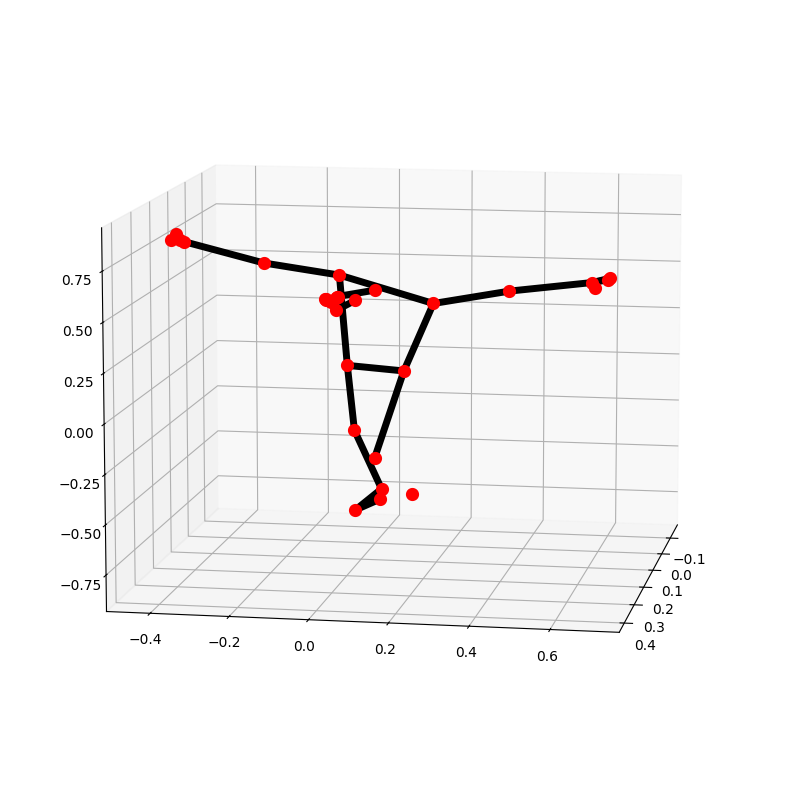

In [7]:
def detectPose(image, pose, display=True):
    output_image = image.copy()
    imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(imageRGB)
    height, width, _ = image.shape
    landmarks = []

    if results.pose_landmarks:
        mp_drawing.draw_landmarks(image=output_image, landmark_list=results.pose_landmarks, connections=mp_pose.POSE_CONNECTIONS)
        for landmark in results.pose_landmarks.landmark:
            landmarks.append((int(landmark.x * width), int(landmark.y * height), (landmark.z * width)))

    if display:
        plt.figure(figsize=[22,22])
        plt.subplot(121); plt.imshow(image[:,:,::-1]); plt.title("Original Image"); plt.axis('off');
        plt.subplot(122); plt.imshow(output_image[:,:,::-1]); plt.title("Output Image"); plt.axis('off');
        mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

    else:
        return output_image, landmarks

image = cv2.imread('../images/unknown.jpg')
detectPose(image, pose, display=True)


##### Angles Calculation :

In [8]:
def calculateAngle(landmark1, landmark2, landmark3):
    x1, y1, _ = landmark1
    x2, y2, _ = landmark2
    x3, y3, _ = landmark3
    angle = math.degrees(math.atan2(y3 - y2, x3 - x2) - math.atan2(y1 - y2, x1 - x2))
    if angle < 0:
        angle += 360
    return angle

angle = calculateAngle((558, 326, 0), (642, 333, 0), (718, 321, 0))
print(f'The calculated angle is {angle}')

The calculated angle is 166.26373169437744


### Pose Classification :

In [18]:
def classifyPose(landmarks, output_image, display=False):
    label = 'Unknown Pose'
    color = (0, 0, 255)
    left_elbow_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value], landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value], landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value])
    right_elbow_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value], landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value], landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value])
    left_shoulder_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value], landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value], landmarks[mp_pose.PoseLandmark.LEFT_HIP.value])
    right_shoulder_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value], landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value], landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value])
    left_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_HIP.value], landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value], landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value])
    right_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value], landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value], landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value])

    if left_elbow_angle > 165 and left_elbow_angle < 195 and right_elbow_angle > 165 and right_elbow_angle < 195:
        if left_shoulder_angle > 80 and left_shoulder_angle < 110 and right_shoulder_angle > 80 and right_shoulder_angle < 110:
            if left_knee_angle > 160 and left_knee_angle < 195 and right_knee_angle > 160 and right_knee_angle < 195:
                label = 'T Pose'

    if label != 'Unknown Pose':
        color = (0,0,255)
    cv2.putText(output_image, label, (10, 30), cv2.FONT_HERSHEY_PLAIN, 2, color, 5)

    if display:
        plt.figure(figsize=[10,10])
        plt.imshow(output_image[:,:,::-1]); plt.title("Output Image"); plt.axis('off');
    else:
        return output_image, label


### Testing :

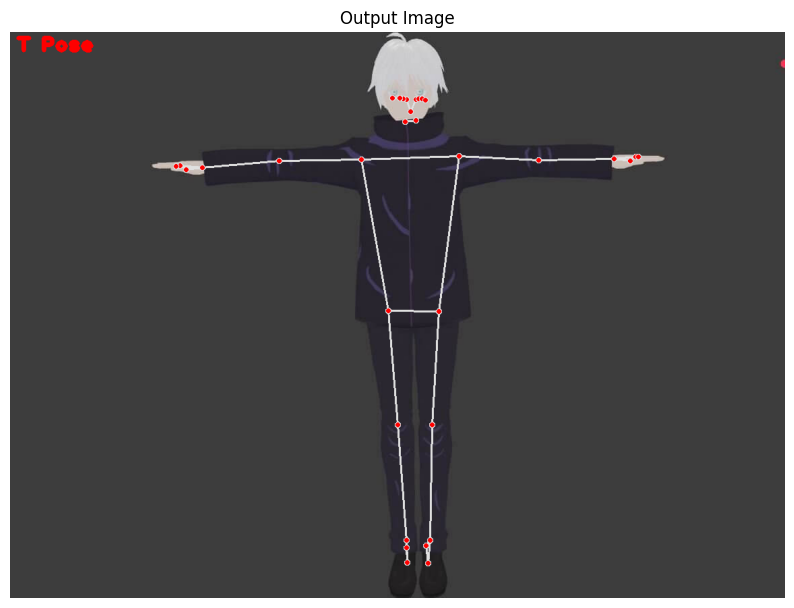

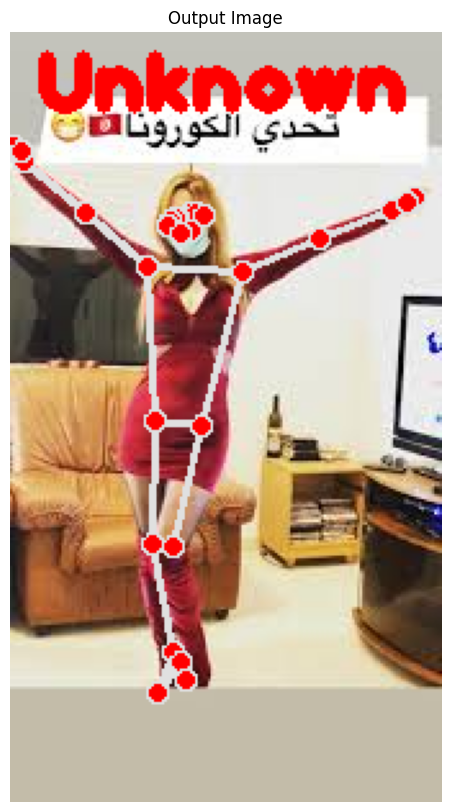

In [19]:
image = cv2.imread('../images/tpose.jpg')
output_image, landmarks = detectPose(image, pose, display=False)
if landmarks:
    classifyPose(landmarks, output_image, display=True)


image = cv2.imread('../images/unknown.jpg')
output_image, landmarks = detectPose(image, pose, display=False)
if landmarks:
    classifyPose(landmarks, output_image, display=True)